<h1>Simple LSTM with Monthly Dataset</h1>

In [1]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')

In [2]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
#     print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [3]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/data.csv'
    king_all_copy, king_data= load_data(chris_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [4]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [5]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [6]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [7]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [8]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
#     print('max val king_train:')
    print(max(king_training['king']))
    king_test[king_test["king"] < 0] = 0
#     print('max val king_test:')
    print(max(king_test['king']))
    king_train_pre = king_training["king"].to_frame()
#     print(king_train_norm)
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)
    print('king_test_norm')
    print(king_test_norm.shape)
    print('king_train_norm')
    print(king_train_norm.shape)
    #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
    #print(type(king_train_norm))
    #king_train_norm = king_train_norm.to_frame()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [9]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)

(60, 2)
717915
294611
king_test_norm
(60, 1)
king_train_norm
(924, 1)
(54, 1)
(54, 1)
(918, 1)
(918, 1)


In [10]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def month_to_year(month_preds):
    month_preds = month_preds[5:]
    print(len(month_preds))
    year_preds = []
    for i in range(12, len(month_preds), 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [12]:
def create_LSTM_model(x_train, y_train, x_test, y_test): 
    '''
    Create LSTM model trained on X_train and Y_train
    and make predictions on the X_test data
    '''
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(5, input_shape=(x_train.shape[1],1), return_sequences=True))
    LSTM_model.add(LSTM(5, return_sequences=True))
    LSTM_model.add(LSTM(5, return_sequences=True))
    LSTM_model.add(LSTM(1))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
    history_LSTM = LSTM_model.fit(x_train, y_train, epochs=3000, batch_size=300, verbose=2)
    
    train_preds = LSTM_model.predict(x_train)
    test_preds = LSTM_model.predict(x_test)
    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    return LSTM_model, test_preds, train_preds, y_test, y_train, history_LSTM

In [13]:
# running LSTM
LSTM_model, test_preds_LSTM, train_preds_LSTM, y_test, y_train, history_LSTM = create_LSTM_model(x_train, y_train, x_test, y_test)

Epoch 1/3000
4/4 - 5s - loss: 0.0113
Epoch 2/3000
4/4 - 0s - loss: 0.0105
Epoch 3/3000
4/4 - 0s - loss: 0.0098
Epoch 4/3000
4/4 - 0s - loss: 0.0094
Epoch 5/3000
4/4 - 0s - loss: 0.0092
Epoch 6/3000
4/4 - 0s - loss: 0.0092
Epoch 7/3000
4/4 - 0s - loss: 0.0093
Epoch 8/3000
4/4 - 0s - loss: 0.0093
Epoch 9/3000
4/4 - 0s - loss: 0.0092
Epoch 10/3000
4/4 - 0s - loss: 0.0092
Epoch 11/3000
4/4 - 0s - loss: 0.0092
Epoch 12/3000
4/4 - 0s - loss: 0.0092
Epoch 13/3000
4/4 - 0s - loss: 0.0092
Epoch 14/3000
4/4 - 0s - loss: 0.0092
Epoch 15/3000
4/4 - 0s - loss: 0.0092
Epoch 16/3000
4/4 - 0s - loss: 0.0092
Epoch 17/3000
4/4 - 0s - loss: 0.0092
Epoch 18/3000
4/4 - 0s - loss: 0.0092
Epoch 19/3000
4/4 - 0s - loss: 0.0092
Epoch 20/3000
4/4 - 0s - loss: 0.0092
Epoch 21/3000
4/4 - 0s - loss: 0.0092
Epoch 22/3000
4/4 - 0s - loss: 0.0092
Epoch 23/3000
4/4 - 0s - loss: 0.0092
Epoch 24/3000
4/4 - 0s - loss: 0.0092
Epoch 25/3000
4/4 - 0s - loss: 0.0092
Epoch 26/3000
4/4 - 0s - loss: 0.0092
Epoch 27/3000
4/4 - 0

Epoch 214/3000
4/4 - 0s - loss: 0.0087
Epoch 215/3000
4/4 - 0s - loss: 0.0087
Epoch 216/3000
4/4 - 0s - loss: 0.0088
Epoch 217/3000
4/4 - 0s - loss: 0.0087
Epoch 218/3000
4/4 - 0s - loss: 0.0087
Epoch 219/3000
4/4 - 0s - loss: 0.0087
Epoch 220/3000
4/4 - 0s - loss: 0.0087
Epoch 221/3000
4/4 - 0s - loss: 0.0087
Epoch 222/3000
4/4 - 0s - loss: 0.0087
Epoch 223/3000
4/4 - 0s - loss: 0.0087
Epoch 224/3000
4/4 - 0s - loss: 0.0087
Epoch 225/3000
4/4 - 0s - loss: 0.0087
Epoch 226/3000
4/4 - 0s - loss: 0.0087
Epoch 227/3000
4/4 - 0s - loss: 0.0087
Epoch 228/3000
4/4 - 0s - loss: 0.0087
Epoch 229/3000
4/4 - 0s - loss: 0.0087
Epoch 230/3000
4/4 - 0s - loss: 0.0087
Epoch 231/3000
4/4 - 0s - loss: 0.0087
Epoch 232/3000
4/4 - 0s - loss: 0.0087
Epoch 233/3000
4/4 - 0s - loss: 0.0087
Epoch 234/3000
4/4 - 0s - loss: 0.0087
Epoch 235/3000
4/4 - 0s - loss: 0.0087
Epoch 236/3000
4/4 - 0s - loss: 0.0087
Epoch 237/3000
4/4 - 0s - loss: 0.0087
Epoch 238/3000
4/4 - 0s - loss: 0.0087
Epoch 239/3000
4/4 - 0s -

4/4 - 0s - loss: 0.0080
Epoch 425/3000
4/4 - 0s - loss: 0.0081
Epoch 426/3000
4/4 - 0s - loss: 0.0081
Epoch 427/3000
4/4 - 0s - loss: 0.0080
Epoch 428/3000
4/4 - 0s - loss: 0.0081
Epoch 429/3000
4/4 - 0s - loss: 0.0079
Epoch 430/3000
4/4 - 0s - loss: 0.0083
Epoch 431/3000
4/4 - 0s - loss: 0.0081
Epoch 432/3000
4/4 - 0s - loss: 0.0079
Epoch 433/3000
4/4 - 0s - loss: 0.0081
Epoch 434/3000
4/4 - 0s - loss: 0.0080
Epoch 435/3000
4/4 - 0s - loss: 0.0079
Epoch 436/3000
4/4 - 0s - loss: 0.0079
Epoch 437/3000
4/4 - 0s - loss: 0.0079
Epoch 438/3000
4/4 - 0s - loss: 0.0080
Epoch 439/3000
4/4 - 0s - loss: 0.0079
Epoch 440/3000
4/4 - 0s - loss: 0.0079
Epoch 441/3000
4/4 - 0s - loss: 0.0079
Epoch 442/3000
4/4 - 0s - loss: 0.0078
Epoch 443/3000
4/4 - 0s - loss: 0.0078
Epoch 444/3000
4/4 - 0s - loss: 0.0078
Epoch 445/3000
4/4 - 0s - loss: 0.0079
Epoch 446/3000
4/4 - 0s - loss: 0.0078
Epoch 447/3000
4/4 - 0s - loss: 0.0077
Epoch 448/3000
4/4 - 0s - loss: 0.0079
Epoch 449/3000
4/4 - 0s - loss: 0.0078
E

Epoch 635/3000
4/4 - 0s - loss: 0.0067
Epoch 636/3000
4/4 - 0s - loss: 0.0068
Epoch 637/3000
4/4 - 0s - loss: 0.0067
Epoch 638/3000
4/4 - 0s - loss: 0.0068
Epoch 639/3000
4/4 - 0s - loss: 0.0066
Epoch 640/3000
4/4 - 0s - loss: 0.0068
Epoch 641/3000
4/4 - 0s - loss: 0.0066
Epoch 642/3000
4/4 - 0s - loss: 0.0070
Epoch 643/3000
4/4 - 0s - loss: 0.0066
Epoch 644/3000
4/4 - 0s - loss: 0.0069
Epoch 645/3000
4/4 - 0s - loss: 0.0068
Epoch 646/3000
4/4 - 0s - loss: 0.0067
Epoch 647/3000
4/4 - 0s - loss: 0.0065
Epoch 648/3000
4/4 - 0s - loss: 0.0066
Epoch 649/3000
4/4 - 0s - loss: 0.0065
Epoch 650/3000
4/4 - 0s - loss: 0.0065
Epoch 651/3000
4/4 - 0s - loss: 0.0066
Epoch 652/3000
4/4 - 0s - loss: 0.0063
Epoch 653/3000
4/4 - 0s - loss: 0.0064
Epoch 654/3000
4/4 - 0s - loss: 0.0063
Epoch 655/3000
4/4 - 0s - loss: 0.0065
Epoch 656/3000
4/4 - 0s - loss: 0.0065
Epoch 657/3000
4/4 - 0s - loss: 0.0064
Epoch 658/3000
4/4 - 0s - loss: 0.0063
Epoch 659/3000
4/4 - 0s - loss: 0.0064
Epoch 660/3000
4/4 - 0s -

4/4 - 0s - loss: 0.0068
Epoch 846/3000
4/4 - 0s - loss: 0.0062
Epoch 847/3000
4/4 - 0s - loss: 0.0075
Epoch 848/3000
4/4 - 0s - loss: 0.0065
Epoch 849/3000
4/4 - 0s - loss: 0.0060
Epoch 850/3000
4/4 - 0s - loss: 0.0060
Epoch 851/3000
4/4 - 0s - loss: 0.0062
Epoch 852/3000
4/4 - 0s - loss: 0.0058
Epoch 853/3000
4/4 - 0s - loss: 0.0070
Epoch 854/3000
4/4 - 0s - loss: 0.0066
Epoch 855/3000
4/4 - 0s - loss: 0.0056
Epoch 856/3000
4/4 - 0s - loss: 0.0057
Epoch 857/3000
4/4 - 0s - loss: 0.0054
Epoch 858/3000
4/4 - 0s - loss: 0.0054
Epoch 859/3000
4/4 - 0s - loss: 0.0054
Epoch 860/3000
4/4 - 0s - loss: 0.0055
Epoch 861/3000
4/4 - 0s - loss: 0.0054
Epoch 862/3000
4/4 - 0s - loss: 0.0057
Epoch 863/3000
4/4 - 0s - loss: 0.0054
Epoch 864/3000
4/4 - 0s - loss: 0.0055
Epoch 865/3000
4/4 - 0s - loss: 0.0054
Epoch 866/3000
4/4 - 0s - loss: 0.0053
Epoch 867/3000
4/4 - 0s - loss: 0.0054
Epoch 868/3000
4/4 - 0s - loss: 0.0055
Epoch 869/3000
4/4 - 0s - loss: 0.0053
Epoch 870/3000
4/4 - 0s - loss: 0.0052
E

4/4 - 0s - loss: 0.0045
Epoch 1055/3000
4/4 - 0s - loss: 0.0047
Epoch 1056/3000
4/4 - 0s - loss: 0.0046
Epoch 1057/3000
4/4 - 0s - loss: 0.0046
Epoch 1058/3000
4/4 - 0s - loss: 0.0045
Epoch 1059/3000
4/4 - 0s - loss: 0.0046
Epoch 1060/3000
4/4 - 0s - loss: 0.0045
Epoch 1061/3000
4/4 - 0s - loss: 0.0045
Epoch 1062/3000
4/4 - 0s - loss: 0.0054
Epoch 1063/3000
4/4 - 0s - loss: 0.0050
Epoch 1064/3000
4/4 - 0s - loss: 0.0045
Epoch 1065/3000
4/4 - 0s - loss: 0.0045
Epoch 1066/3000
4/4 - 0s - loss: 0.0051
Epoch 1067/3000
4/4 - 0s - loss: 0.0048
Epoch 1068/3000
4/4 - 0s - loss: 0.0050
Epoch 1069/3000
4/4 - 0s - loss: 0.0045
Epoch 1070/3000
4/4 - 0s - loss: 0.0047
Epoch 1071/3000
4/4 - 0s - loss: 0.0045
Epoch 1072/3000
4/4 - 0s - loss: 0.0048
Epoch 1073/3000
4/4 - 0s - loss: 0.0044
Epoch 1074/3000
4/4 - 0s - loss: 0.0047
Epoch 1075/3000
4/4 - 0s - loss: 0.0046
Epoch 1076/3000
4/4 - 0s - loss: 0.0047
Epoch 1077/3000
4/4 - 0s - loss: 0.0049
Epoch 1078/3000
4/4 - 0s - loss: 0.0045
Epoch 1079/3000


4/4 - 0s - loss: 0.0052
Epoch 1260/3000
4/4 - 0s - loss: 0.0052
Epoch 1261/3000
4/4 - 0s - loss: 0.0051
Epoch 1262/3000
4/4 - 0s - loss: 0.0044
Epoch 1263/3000
4/4 - 0s - loss: 0.0047
Epoch 1264/3000
4/4 - 0s - loss: 0.0044
Epoch 1265/3000
4/4 - 0s - loss: 0.0044
Epoch 1266/3000
4/4 - 0s - loss: 0.0045
Epoch 1267/3000
4/4 - 0s - loss: 0.0043
Epoch 1268/3000
4/4 - 0s - loss: 0.0047
Epoch 1269/3000
4/4 - 0s - loss: 0.0044
Epoch 1270/3000
4/4 - 0s - loss: 0.0044
Epoch 1271/3000
4/4 - 0s - loss: 0.0045
Epoch 1272/3000
4/4 - 0s - loss: 0.0043
Epoch 1273/3000
4/4 - 0s - loss: 0.0047
Epoch 1274/3000
4/4 - 0s - loss: 0.0045
Epoch 1275/3000
4/4 - 0s - loss: 0.0048
Epoch 1276/3000
4/4 - 0s - loss: 0.0044
Epoch 1277/3000
4/4 - 0s - loss: 0.0048
Epoch 1278/3000
4/4 - 0s - loss: 0.0043
Epoch 1279/3000
4/4 - 0s - loss: 0.0048
Epoch 1280/3000
4/4 - 0s - loss: 0.0043
Epoch 1281/3000
4/4 - 0s - loss: 0.0049
Epoch 1282/3000
4/4 - 0s - loss: 0.0044
Epoch 1283/3000
4/4 - 0s - loss: 0.0044
Epoch 1284/3000


4/4 - 0s - loss: 0.0048
Epoch 1465/3000
4/4 - 0s - loss: 0.0042
Epoch 1466/3000
4/4 - 0s - loss: 0.0043
Epoch 1467/3000
4/4 - 0s - loss: 0.0042
Epoch 1468/3000
4/4 - 0s - loss: 0.0043
Epoch 1469/3000
4/4 - 0s - loss: 0.0043
Epoch 1470/3000
4/4 - 0s - loss: 0.0042
Epoch 1471/3000
4/4 - 0s - loss: 0.0043
Epoch 1472/3000
4/4 - 0s - loss: 0.0045
Epoch 1473/3000
4/4 - 0s - loss: 0.0044
Epoch 1474/3000
4/4 - 0s - loss: 0.0044
Epoch 1475/3000
4/4 - 0s - loss: 0.0042
Epoch 1476/3000
4/4 - 0s - loss: 0.0044
Epoch 1477/3000
4/4 - 0s - loss: 0.0062
Epoch 1478/3000
4/4 - 0s - loss: 0.0058
Epoch 1479/3000
4/4 - 0s - loss: 0.0053
Epoch 1480/3000
4/4 - 0s - loss: 0.0046
Epoch 1481/3000
4/4 - 0s - loss: 0.0065
Epoch 1482/3000
4/4 - 0s - loss: 0.0052
Epoch 1483/3000
4/4 - 0s - loss: 0.0047
Epoch 1484/3000
4/4 - 0s - loss: 0.0056
Epoch 1485/3000
4/4 - 0s - loss: 0.0070
Epoch 1486/3000
4/4 - 0s - loss: 0.0054
Epoch 1487/3000
4/4 - 0s - loss: 0.0059
Epoch 1488/3000
4/4 - 0s - loss: 0.0047
Epoch 1489/3000


4/4 - 0s - loss: 0.0055
Epoch 1670/3000
4/4 - 0s - loss: 0.0043
Epoch 1671/3000
4/4 - 0s - loss: 0.0047
Epoch 1672/3000
4/4 - 0s - loss: 0.0045
Epoch 1673/3000
4/4 - 0s - loss: 0.0045
Epoch 1674/3000
4/4 - 0s - loss: 0.0042
Epoch 1675/3000
4/4 - 0s - loss: 0.0050
Epoch 1676/3000
4/4 - 0s - loss: 0.0043
Epoch 1677/3000
4/4 - 0s - loss: 0.0047
Epoch 1678/3000
4/4 - 0s - loss: 0.0043
Epoch 1679/3000
4/4 - 0s - loss: 0.0054
Epoch 1680/3000
4/4 - 0s - loss: 0.0045
Epoch 1681/3000
4/4 - 0s - loss: 0.0047
Epoch 1682/3000
4/4 - 0s - loss: 0.0049
Epoch 1683/3000
4/4 - 0s - loss: 0.0048
Epoch 1684/3000
4/4 - 0s - loss: 0.0046
Epoch 1685/3000
4/4 - 0s - loss: 0.0044
Epoch 1686/3000
4/4 - 0s - loss: 0.0044
Epoch 1687/3000
4/4 - 0s - loss: 0.0045
Epoch 1688/3000
4/4 - 0s - loss: 0.0062
Epoch 1689/3000
4/4 - 0s - loss: 0.0095
Epoch 1690/3000
4/4 - 0s - loss: 0.0046
Epoch 1691/3000
4/4 - 0s - loss: 0.0062
Epoch 1692/3000
4/4 - 0s - loss: 0.0048
Epoch 1693/3000
4/4 - 0s - loss: 0.0047
Epoch 1694/3000


4/4 - 0s - loss: 0.0041
Epoch 1875/3000
4/4 - 0s - loss: 0.0041
Epoch 1876/3000
4/4 - 0s - loss: 0.0040
Epoch 1877/3000
4/4 - 0s - loss: 0.0041
Epoch 1878/3000
4/4 - 0s - loss: 0.0040
Epoch 1879/3000
4/4 - 0s - loss: 0.0041
Epoch 1880/3000
4/4 - 0s - loss: 0.0040
Epoch 1881/3000
4/4 - 0s - loss: 0.0040
Epoch 1882/3000
4/4 - 0s - loss: 0.0041
Epoch 1883/3000
4/4 - 0s - loss: 0.0040
Epoch 1884/3000
4/4 - 0s - loss: 0.0042
Epoch 1885/3000
4/4 - 0s - loss: 0.0040
Epoch 1886/3000
4/4 - 0s - loss: 0.0042
Epoch 1887/3000
4/4 - 0s - loss: 0.0041
Epoch 1888/3000
4/4 - 0s - loss: 0.0041
Epoch 1889/3000
4/4 - 0s - loss: 0.0040
Epoch 1890/3000
4/4 - 0s - loss: 0.0041
Epoch 1891/3000
4/4 - 0s - loss: 0.0040
Epoch 1892/3000
4/4 - 0s - loss: 0.0040
Epoch 1893/3000
4/4 - 0s - loss: 0.0040
Epoch 1894/3000
4/4 - 0s - loss: 0.0040
Epoch 1895/3000
4/4 - 0s - loss: 0.0042
Epoch 1896/3000
4/4 - 0s - loss: 0.0046
Epoch 1897/3000
4/4 - 0s - loss: 0.0041
Epoch 1898/3000
4/4 - 0s - loss: 0.0041
Epoch 1899/3000


Epoch 2080/3000
4/4 - 0s - loss: 0.0039
Epoch 2081/3000
4/4 - 0s - loss: 0.0040
Epoch 2082/3000
4/4 - 0s - loss: 0.0042
Epoch 2083/3000
4/4 - 0s - loss: 0.0040
Epoch 2084/3000
4/4 - 0s - loss: 0.0040
Epoch 2085/3000
4/4 - 0s - loss: 0.0039
Epoch 2086/3000
4/4 - 0s - loss: 0.0039
Epoch 2087/3000
4/4 - 0s - loss: 0.0040
Epoch 2088/3000
4/4 - 0s - loss: 0.0040
Epoch 2089/3000
4/4 - 0s - loss: 0.0039
Epoch 2090/3000
4/4 - 0s - loss: 0.0040
Epoch 2091/3000
4/4 - 0s - loss: 0.0041
Epoch 2092/3000
4/4 - 0s - loss: 0.0040
Epoch 2093/3000
4/4 - 0s - loss: 0.0044
Epoch 2094/3000
4/4 - 0s - loss: 0.0040
Epoch 2095/3000
4/4 - 0s - loss: 0.0042
Epoch 2096/3000
4/4 - 0s - loss: 0.0039
Epoch 2097/3000
4/4 - 0s - loss: 0.0040
Epoch 2098/3000
4/4 - 0s - loss: 0.0040
Epoch 2099/3000
4/4 - 0s - loss: 0.0040
Epoch 2100/3000
4/4 - 0s - loss: 0.0040
Epoch 2101/3000
4/4 - 0s - loss: 0.0039
Epoch 2102/3000
4/4 - 0s - loss: 0.0039
Epoch 2103/3000
4/4 - 0s - loss: 0.0043
Epoch 2104/3000
4/4 - 0s - loss: 0.0041


Epoch 2285/3000
4/4 - 0s - loss: 0.0039
Epoch 2286/3000
4/4 - 0s - loss: 0.0039
Epoch 2287/3000
4/4 - 0s - loss: 0.0039
Epoch 2288/3000
4/4 - 0s - loss: 0.0038
Epoch 2289/3000
4/4 - 0s - loss: 0.0039
Epoch 2290/3000
4/4 - 0s - loss: 0.0042
Epoch 2291/3000
4/4 - 0s - loss: 0.0041
Epoch 2292/3000
4/4 - 0s - loss: 0.0043
Epoch 2293/3000
4/4 - 0s - loss: 0.0042
Epoch 2294/3000
4/4 - 0s - loss: 0.0040
Epoch 2295/3000
4/4 - 0s - loss: 0.0051
Epoch 2296/3000
4/4 - 0s - loss: 0.0073
Epoch 2297/3000
4/4 - 0s - loss: 0.0043
Epoch 2298/3000
4/4 - 0s - loss: 0.0054
Epoch 2299/3000
4/4 - 0s - loss: 0.0043
Epoch 2300/3000
4/4 - 0s - loss: 0.0042
Epoch 2301/3000
4/4 - 0s - loss: 0.0040
Epoch 2302/3000
4/4 - 0s - loss: 0.0041
Epoch 2303/3000
4/4 - 0s - loss: 0.0039
Epoch 2304/3000
4/4 - 0s - loss: 0.0041
Epoch 2305/3000
4/4 - 0s - loss: 0.0039
Epoch 2306/3000
4/4 - 0s - loss: 0.0038
Epoch 2307/3000
4/4 - 0s - loss: 0.0039
Epoch 2308/3000
4/4 - 0s - loss: 0.0042
Epoch 2309/3000
4/4 - 0s - loss: 0.0039


Epoch 2490/3000
4/4 - 0s - loss: 0.0040
Epoch 2491/3000
4/4 - 0s - loss: 0.0040
Epoch 2492/3000
4/4 - 0s - loss: 0.0041
Epoch 2493/3000
4/4 - 0s - loss: 0.0039
Epoch 2494/3000
4/4 - 0s - loss: 0.0039
Epoch 2495/3000
4/4 - 0s - loss: 0.0056
Epoch 2496/3000
4/4 - 0s - loss: 0.0065
Epoch 2497/3000
4/4 - 0s - loss: 0.0050
Epoch 2498/3000
4/4 - 0s - loss: 0.0056
Epoch 2499/3000
4/4 - 0s - loss: 0.0049
Epoch 2500/3000
4/4 - 0s - loss: 0.0053
Epoch 2501/3000
4/4 - 0s - loss: 0.0046
Epoch 2502/3000
4/4 - 0s - loss: 0.0050
Epoch 2503/3000
4/4 - 0s - loss: 0.0050
Epoch 2504/3000
4/4 - 0s - loss: 0.0043
Epoch 2505/3000
4/4 - 0s - loss: 0.0042
Epoch 2506/3000
4/4 - 0s - loss: 0.0041
Epoch 2507/3000
4/4 - 0s - loss: 0.0039
Epoch 2508/3000
4/4 - 0s - loss: 0.0039
Epoch 2509/3000
4/4 - 0s - loss: 0.0039
Epoch 2510/3000
4/4 - 0s - loss: 0.0039
Epoch 2511/3000
4/4 - 0s - loss: 0.0039
Epoch 2512/3000
4/4 - 0s - loss: 0.0038
Epoch 2513/3000
4/4 - 0s - loss: 0.0038
Epoch 2514/3000
4/4 - 0s - loss: 0.0037


Epoch 2695/3000
4/4 - 0s - loss: 0.0037
Epoch 2696/3000
4/4 - 0s - loss: 0.0049
Epoch 2697/3000
4/4 - 0s - loss: 0.0081
Epoch 2698/3000
4/4 - 0s - loss: 0.0042
Epoch 2699/3000
4/4 - 0s - loss: 0.0094
Epoch 2700/3000
4/4 - 0s - loss: 0.0081
Epoch 2701/3000
4/4 - 0s - loss: 0.0068
Epoch 2702/3000
4/4 - 0s - loss: 0.0055
Epoch 2703/3000
4/4 - 0s - loss: 0.0057
Epoch 2704/3000
4/4 - 0s - loss: 0.0060
Epoch 2705/3000
4/4 - 0s - loss: 0.0056
Epoch 2706/3000
4/4 - 0s - loss: 0.0052
Epoch 2707/3000
4/4 - 0s - loss: 0.0050
Epoch 2708/3000
4/4 - 0s - loss: 0.0060
Epoch 2709/3000
4/4 - 0s - loss: 0.0100
Epoch 2710/3000
4/4 - 0s - loss: 0.0068
Epoch 2711/3000
4/4 - 0s - loss: 0.0039
Epoch 2712/3000
4/4 - 0s - loss: 0.0047
Epoch 2713/3000
4/4 - 0s - loss: 0.0044
Epoch 2714/3000
4/4 - 0s - loss: 0.0039
Epoch 2715/3000
4/4 - 0s - loss: 0.0041
Epoch 2716/3000
4/4 - 0s - loss: 0.0040
Epoch 2717/3000
4/4 - 0s - loss: 0.0038
Epoch 2718/3000
4/4 - 0s - loss: 0.0038
Epoch 2719/3000
4/4 - 0s - loss: 0.0038


Epoch 2900/3000
4/4 - 0s - loss: 0.0036
Epoch 2901/3000
4/4 - 0s - loss: 0.0036
Epoch 2902/3000
4/4 - 0s - loss: 0.0035
Epoch 2903/3000
4/4 - 0s - loss: 0.0036
Epoch 2904/3000
4/4 - 0s - loss: 0.0035
Epoch 2905/3000
4/4 - 0s - loss: 0.0036
Epoch 2906/3000
4/4 - 0s - loss: 0.0035
Epoch 2907/3000
4/4 - 0s - loss: 0.0035
Epoch 2908/3000
4/4 - 0s - loss: 0.0035
Epoch 2909/3000
4/4 - 0s - loss: 0.0036
Epoch 2910/3000
4/4 - 0s - loss: 0.0036
Epoch 2911/3000
4/4 - 0s - loss: 0.0035
Epoch 2912/3000
4/4 - 0s - loss: 0.0035
Epoch 2913/3000
4/4 - 0s - loss: 0.0035
Epoch 2914/3000
4/4 - 0s - loss: 0.0035
Epoch 2915/3000
4/4 - 0s - loss: 0.0035
Epoch 2916/3000
4/4 - 0s - loss: 0.0036
Epoch 2917/3000
4/4 - 0s - loss: 0.0035
Epoch 2918/3000
4/4 - 0s - loss: 0.0036
Epoch 2919/3000
4/4 - 0s - loss: 0.0035
Epoch 2920/3000
4/4 - 0s - loss: 0.0039
Epoch 2921/3000
4/4 - 0s - loss: 0.0036
Epoch 2922/3000
4/4 - 0s - loss: 0.0037
Epoch 2923/3000
4/4 - 0s - loss: 0.0036
Epoch 2924/3000
4/4 - 0s - loss: 0.0035


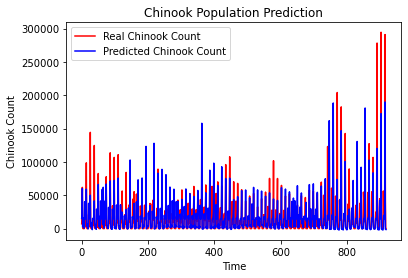

The root mean squared error is 17875.7577855883.


In [14]:
plot_predictions(y_train, train_preds_LSTM)
return_rmse(y_train, train_preds_LSTM)

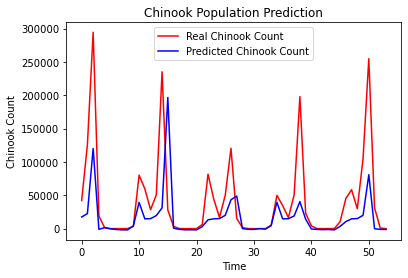

The root mean squared error is 60732.446796151184.


In [15]:
plot_predictions(y_test, test_preds_LSTM)
return_rmse(y_test, test_preds_LSTM)

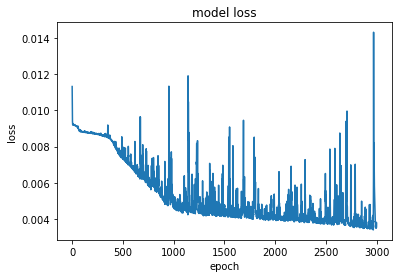

In [16]:
plot_loss(history_LSTM)

In [17]:
# global var for baseline
y_test_year = month_to_year(y_test)
len(y_test)
len(y_test_year)

49


4

In [18]:
y_test_year = month_to_year(y_test)
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_chris_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)
y_test_year = y_test_year.astype(np.int64)
print(y_test_year)
# print(GRU_test_year)

49
    Count
0  498710
1  439060
2  294840
3  347600
    Count
0  488943
1  336031
2  381766
3  535809


In [19]:
# Comparing RMSE to curr Forecasting methods to LSTM
LSTM_test_year = month_to_year(test_preds_LSTM)
LSTM_test_year = LSTM_test_year.astype(np.int64)

49


In [20]:
LSTM_test_year

,Count
0,315542
1,151571
2,143755
3,137088


In [21]:
# test RMSE with baseline and LSTM
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, LSTM_test_year)

The root mean squared error is 115854.5707848853.
The root mean squared error is 264443.31640400743.
